In [1]:
import gym
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import pandas_profiling as pdp

In [2]:
# モデルの読み込み
env = gym.make("CartPole-v0")

In [3]:
"""Qネットワーク全体を1つのオブジェクトとして扱えるようにする"""


class QNetwork:
    def __init__(
        self,
        learning_rate=0.01,
        state_size=4,  # 台車と棒の状態
        action_size=2,  # 左右
        hidden_size=10,  # 隠れ層のunit数
        name="QNetwork",
    ):
        with tf.variable_scope(name):
            # サイズは未定のためNone
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.int32, [None], name="actions")
            # actions_のベクトル化 (One-Hot-Encoding)
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            # 最終的なQ値
            self.targetQs_ = tf.placeholder(tf.float32, [None], name="target")

            # Tensor("main/fully_connected/Relu:0", shape=(?, 64), dtype=float32)
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            # Tensor("main/fully_connected_1/Relu:0", shape=(?, 64), dtype=float32)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            # Tensor("main/fully_connected_2/BiasAdd:0", shape=(?, 2), dtype=float32)
            self.output = tf.contrib.layers.fully_connected(
                self.fc2, action_size, activation_fn=None
            )

            # Q値の予測値を求める, 行列のかけ算をして足し算をする, axisは出力データの次元
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            # 損失関数
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            tf.summary.scalar("loss", self.loss)
            # Adam（動的に学習率を調整）による最適化
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [4]:
from collections import deque

"""
トレーニングセットの作成
-> 試行の順序によるばらつきを抑える
-> 試行結果を保存するクラスを作成する

・Experience Replay
    <st, at, rt, st+1>をランダムに取得
・Memory Objectに格納
    Double Ended Queue（はみ出すと対端を落とす）
・無作為抽出
"""
class Memory:
    def __init__(self, max_size=1000):
        # DoubleEndedQueueの初期化
        self.buffer = deque(maxlen=max_size)

    # DoubleEndedQueueにデータ（経験）を末尾に追加
    def add(self, experience):
        self.buffer.append(experience)

    # 無作為抽出
    def sample(self, batch_size):
        # replace=False: 重複なし
        idx = np.random.choice(
            np.arange(len(self.buffer)), size=batch_size, replace=False
        )
        return [self.buffer[ii] for ii in idx]

In [5]:
# ハイパーパラメータの定義と初期化
train_episodes = 1000
max_step = 200
gamma = 0.99  # 割引率

# 探索のパラメータをepisodesが進むにつれて減衰させる
explore_start = 1.0
explore_stop = 0.01
decay_rate = 0.0001

hidden_size = 64
learning_rate = 0.0001

memory_size = 10000
batch_size = 20
# 最初にメモリを処理するためのサイズ
pretrain_length = batch_size

In [6]:
tf.reset_default_graph()

In [7]:
mainQN = QNetwork(name="main", hidden_size=hidden_size, learning_rate=learning_rate)

In [20]:
"""エクスペリエンスメモリーを埋める"""
# 環境のリセット
env.reset()

# 最初の手を打つ, 初期化
state, reward, done, _ = env.step(env.action_space.sample())

# memoryオブジェクトの初期化
memory = Memory(max_size=memory_size)

# トレーニングセットの作成
for ii in tqdm(range(pretrain_length)):
    # ランダムな手を打つ
    action = env.action_space.sample()
    # actionに対する結果の取得
    next_state, reward, done, _ = env.step(action)

    if done:
        # 次のstateはない
        next_state = np.zeros(state.shape)
        # experienceを貯める
        memory.add((state, action, reward, next_state))
        # 環境のリセット
        env.reset()
        # ランダムな手を打つ
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # experienceを貯める
        memory.add((state, action, reward, next_state))
        # stateの更新
        state = next_state

# トレーニングデータセットの可視化
train_df = pd.DataFrame(
    list(memory.buffer), columns=["state", "action", "reward", "next_state"]
)
pdp.ProfileReport(train_df)

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

Number of variables,4
Number of observations,20
Total Missing (%),0.0%
Total size in memory,720.0 B
Average record size in memory,36.0 B
Numeric,0
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,1


In [ ]:
"""トレーニング"""
saver = tf.train.Saver()
# 最終的な報酬のリスト
rewards_list = []
# explore_pのリスト
e_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    merged = tf.summary.merge_all()
    writer = tf.summary.FileWriter("./logs", sess.graph)

    step = 0
    for ep in tqdm(range(1, train_episodes)):
        total_rewards = 0
        t = 0
        while t < max_step:
            step += 1
            
            # イプシロン・グリーディ法
            # ランダムな手を打つ確率を計算する
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(
                -decay_rate * step
            )
            e_list.append(explore_p)
            if explore_p > np.random.rand():
                # ランダムな手を打つ
                action = env.action_space.sample()
            else:
                # 良いスコアの手を打つ
                Qs = sess.run(
                    mainQN.output,
                    feed_dict={mainQN.inputs_: state.reshape((1, *state.shape))},
                )
                action = np.argmax(Qs)

            # 手を打った結果を取得
            next_state, reward, done, _ = env.step(action)
            # 報酬の累積和を更新
            total_rewards += reward

            if done:
                # 次のstateはなし
                next_state = np.zeros(state.shape)
                # 試行回数をmax_stepとする
                t = max_step

#                 if ep % 100 == 0:
#                     print(
#                         "Episode: {}".format(ep),
#                         "Total Reward: {}".format(total_rewards),
#                         "Total Loss: {:.4f}".format(loss),
#                         "Explore Prob: {:.4f}".format(explore_p),
#                     )

                # 報酬リストの更新
                rewards_list.append((ep, total_rewards))
                # experienceを末尾に追加
                memory.add((state, action, reward, next_state))
                # 環境をリセット
                env.reset()
                # ランダムな手を打った結果を取得する
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                # experienceを末尾に追加
                memory.add((state, action, reward, next_state))
                # next_stateに移る
                state = next_state
                t += 1

            # 無作為抽出し，4つのstateをarrayにセットする
            batch = memory.sample(batch_size)
            print(batch)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])

            # Q値の予測値を求める
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            # endsの設定, 1番目の要素でソート
            episode_ends = (next_states == np.zeros(state[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)

            # Q値の更新
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            # 学習
            loss, _, _merged = sess.run(
                [mainQN.loss, mainQN.opt, merged],
                feed_dict={
                    mainQN.inputs_: states,
                    mainQN.targetQs_: targets,
                    mainQN.actions_: actions,
                },
            )
            writer.add_summary(_merged)
            writer.flush()
    writer.close()

    saver.save(sess, "checkpoints/cartpole_dqn.ckpt")

In [10]:
"""トレーニングの結果を可視化しよう"""
%matplotlib inline
import matplotlib.pyplot as plt

# 移動平均
def running_mean(x, N):
    # 累積和を求める
    cumsum = np.cumsum(np.insert(x,0,0))
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total Rewards')

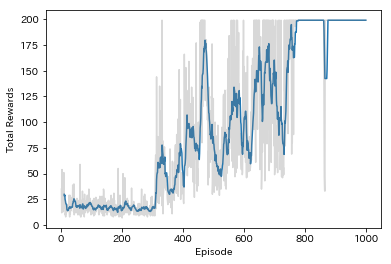

In [16]:
# [(エピソード番号, 報酬和), (),,,] -> [(エピソード番号, #, #, #), (報酬和, #, #, #)]に変換する
eps, rews = np.array(rewards_list).T
# 移動平均
smoothed_rews = running_mean(rews, 10)
# エピソード番号と移動平均
plt.plot(eps[-len(smoothed_rews) :], smoothed_rews)
# エピソード番号と報酬和
plt.plot(eps, rews, color="grey", alpha=0.3)
plt.xlabel("Episode")
plt.ylabel("Total Rewards")

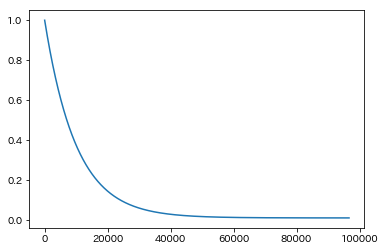

In [17]:
plt.plot(e_list)

In [18]:
"""テストを実行する（レンダリング）"""
test_episodes = 10
test_max_steps = 400

# 環境をリセットする
env.reset()

with tf.Session() as sess:
    # 最新のチェックポイント
    saver.restore(sess, tf.train.latest_checkpoint("checkpoints"))

    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            # レンダリングする
            env.render()
            
            # Q値の予測値を取得する
            Qs = sess.run(
                mainQN.output,
                feed_dict={mainQN.inputs_: state.reshape((1, *state.shape))},
            )
            # aを決定
            action = np.argmax(Qs)

            # aによる結果の取得
            next_state, reward, done, _ = env.step(action)

            if done:
                # 終了
                t = test_max_steps
                # 環境をリセットする
                env.reset()
                # ランダムな手を打つ
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # 次のステップ
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole_dqn.ckpt
